In [51]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [52]:
df = pd.read_csv('C:\\Users\\x230252\\Documents\\Rodolfo\\Pyhton Project\\ML Zoomcamp\\week3\\data.csv')

In [53]:
columns_used = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type',  'Vehicle Style',
       'highway MPG', 'city mpg','MSRP']
df_new = df[columns_used].copy()

In [54]:
df_new.columns = df_new.columns.str.lower().str.replace(' ', '_') #Lowercase the column names and replace spaces with underscores
df_new.fillna(0, inplace=True) #Fill the missing values with 0

In [55]:
mean = df_new['msrp'].mean()

df_new['above_average'] = np.where(df_new['msrp']>mean,1,0)

In [56]:
df_new = df_new.drop('msrp', axis=1)

In [57]:
categorical =['make','model','transmission_type','vehicle_style']
numerical = list(df_new.columns[df_new.dtypes != "object"])

In [58]:
numerical.pop(5)

'above_average'

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
df_train_full, df_test = train_test_split(df_new, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [61]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [62]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [63]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable\
Use the training dataset for that\
If your AUC is < 0.5, invert this variable by putting "-" in front\

(e.g. -df_train['engine_hp']) 

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation\by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
#@ CALCULATING ROC AUC SCORE:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673


- Q1 Answer: engine_hp, 0.917

Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [66]:
from sklearn.feature_extraction import DictVectorizer

In [67]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [74]:
y_pred = model.predict_proba(X_val)[:,1]

In [75]:
roc_auc_score(y_val, y_pred)

0.9790336815928319

- Q2 Answer: 0.979

Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01\
For each threshold, compute precision and recall\
Plot them\
At which threshold precision and recall curves intersect?

In [76]:
#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,334,10,1395
20,0.2,623,201,31,1528
30,0.3,605,144,49,1585
40,0.4,590,106,64,1623
50,0.5,570,73,84,1656
60,0.6,550,51,104,1678
70,0.7,506,30,148,1699
80,0.8,464,21,190,1708
90,0.9,376,3,278,1726


In [77]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

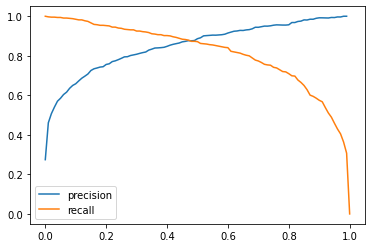

In [78]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

- Q3 Answer: 0.48

Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 

Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

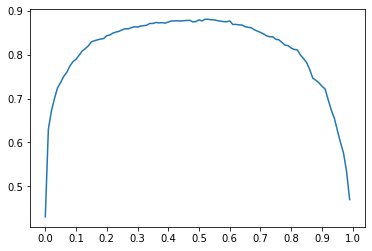

In [79]:
#@ GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
     

#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

- Q4 Answer: 0.52

Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)\
Iterate over different folds of df_full_train\
Split the data into train and validation\
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\
Use AUC to evaluate the model on validation\
How large is standard devidation of the scores across different folds?

In [80]:
from sklearn.model_selection import KFold

In [81]:
# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [84]:
columns=numerical+categorical

In [85]:
columns

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'make',
 'model',
 'transmission_type',
 'vehicle_style']

In [86]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.003


- Q5 Answer: +- 0.003

Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]\
Initialize KFold with the same parameters as previously\
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)\
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)\
Which C leads to the best mean score?

In [90]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.978 +- 0.001
C=  10, 0.983 +- 0.003


- Q6 Answer: C=10